<a href="https://colab.research.google.com/github/AlterCJ/denteeth/blob/main/Machine%20Learning/Denteeth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

In [ ]:
import itertools
import os
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
module_selection = ("mobilenet_v2_100_224", 224)
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 32

Using https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4 with input size (224, 224)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir='drive/MyDrive/denteeth/image'

In [ ]:
datagen_rescale = dict(rescale=1./255, validation_split=.20)
dataflow_resize = dict(target_size=IMAGE_SIZE,
                       batch_size=BATCH_SIZE,
                       interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator( **datagen_rescale)
valid_generator = valid_datagen.flow_from_directory(data_dir,
                                                    subset="validation", 
                                                    shuffle=False, **dataflow_resize)

do_data_augmentation = True 
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=40,
                                                                  horizontal_flip=True,
                                                                  width_shift_range=0.2, height_shift_range=0.2,
                                                                  shear_range=0.2, zoom_range=0.2,
                                                                  **datagen_rescale)
else:
  train_datagen = valid_datagen

train_generator = train_datagen.flow_from_directory(data_dir, 
                                                    subset="training", 
                                                    shuffle=True, **dataflow_resize)

Found 40 images belonging to 2 classes.
Found 160 images belonging to 2 classes.


In [ ]:
do_fine_tuning = False

In [20]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [31]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), 
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])

In [32]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size

history = model.fit(train_generator,
                              epochs=25, steps_per_epoch=steps_per_epoch,
                              validation_data=valid_generator,
                              validation_steps=validation_steps).history

Epoch 1/25
5/5 [==============================] - 87s 18s/step - loss: 1.0215 - accuracy: 0.8125 - val_loss: 1.2391 - val_accuracy: 0.6250
Epoch 2/25
5/5 [==============================] - 82s 17s/step - loss: 0.8487 - accuracy: 0.8813 - val_loss: 0.9609 - val_accuracy: 0.7812
Epoch 3/25
5/5 [==============================] - 82s 17s/step - loss: 0.9352 - accuracy: 0.8438 - val_loss: 1.2354 - val_accuracy: 0.6250
Epoch 4/25
5/5 [==============================] - 83s 17s/step - loss: 0.9406 - accuracy: 0.8375 - val_loss: 1.5162 - val_accuracy: 0.6562
Epoch 5/25
5/5 [==============================] - 82s 17s/step - loss: 0.7995 - accuracy: 0.8750 - val_loss: 1.4932 - val_accuracy: 0.6250
Epoch 6/25
5/5 [==============================] - 82s 17s/step - loss: 0.8255 - accuracy: 0.8687 - val_loss: 1.0376 - val_accuracy: 0.7188
Epoch 7/25
5/5 [==============================] - 83s 17s/step - loss: 0.7923 - accuracy: 0.8500 - val_loss: 1.4640 - val_accuracy: 0.6562
Epoch 8/25
5/5 [===========

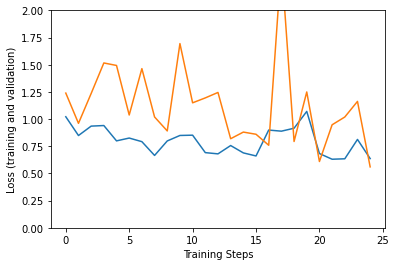

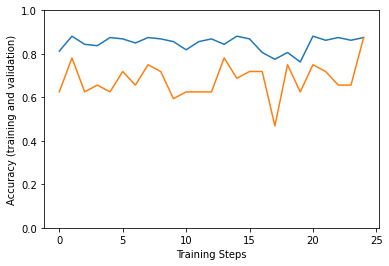

In [33]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(history["loss"])
plt.plot(history["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(history["accuracy"])
plt.plot(history["val_accuracy"])

In [34]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpa1k4cgk0/assets


INFO:tensorflow:Assets written to: /tmp/tmpa1k4cgk0/assets
